# Homework 05: Kernel Density Estimation, Covariance and Correlation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess

In [2]:
import scipy.stats

In [3]:
from sklearn import neighbors, cluster

Helpers for Getting, Loading and Locating Data

In [4]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Problem 1</span>

In this problem you will implement the core of the E- and M-steps for the [Gaussian mixture model (GMM)](http://scikit-learn.org/stable/modules/mixture.html) method. Note the similarities with the E- and M-steps of the K-means method.

First, implement the function below to evaluate the [multidimensional Gaussian probability density](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for arbitrary mean $\vec{\mu}$ and covariance matrix $C$ (refer to the lecture for more details on the notation used here):

$$ \Large
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$

In [5]:
def Gaussian_pdf(x, mu, C):
    """Evaluate the Gaussian probability density.

    Parameters
    ----------
    x : array
        1D array of D feature values for a single sample
    mu : array
        1D array of D mean feature values for this component.
    C : array
        2D array with shape (D, D) of covariance matrix elements for this component.
        Must be positive definite (and therefore symmetric).

    Returns
    -------
    float
        Probability density.
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    C = np.asarray(C)
    D = len(x)
    assert x.shape == (D,) and mu.shape == (D,)
    assert C.shape == (D, D)
    assert np.allclose(C.T, C)

    # YOUR CODE HERE
    diff = x - mu
    invC = np.linalg.inv(C)
    detC = np.linalg.det(C)
    norm = (2.0 * np.pi) ** (-D / 2.0) * detC ** (-0.5)
    expo = -0.5 * (diff @ invC @ diff)
    return float(norm * np.exp(expo))
    #raise NotImplementedError()

In [6]:
# A correct solution should pass these tests.
assert np.allclose(Gaussian_pdf([0], [0], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([1], [1], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([0], [0], [[2]]), 1 / np.sqrt(4 * np.pi))
assert np.allclose(Gaussian_pdf([1], [0], [[1]]), np.exp(-0.5) / np.sqrt(2 * np.pi))

assert np.allclose(Gaussian_pdf([0, 0], [0, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, -1], [1, -1], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[4, 0], [0, 1]]), 1 / (4 * np.pi))

assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, +1], [+1, 1]]), 5) == 0.07778
assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, -1], [-1, 1]]), 5) == 0.07778
assert np.round(np.log(Gaussian_pdf([1, 0, -1], [1, 2, 3], [[4, -1, 0], [-1, 1, 0], [0, 0, 2]])), 5) == -10.31936

Next, implement the E-step in the function below. This consists of calculating the relative probability that each sample $\vec{x}_n$ ($n$-th row of $X$) belongs to each component $k$:

$$ \Large
p_{nk} = \frac{\omega_k G(\vec{x}_n; \vec{\mu}_k, C_k)}
{\sum_{j=1}^K\, \omega_j G(\vec{x}_n; \vec{\mu}_j, C_j)}
$$

Note that these relative probabilities (also called *responsibilities*) sum to one over components $k$ for each sample $n$.  Also note that we consider the parameters ($\omega_k$, $\vec{\mu}_k$, $C_k$) of each component fixed during this step. *Hint: use your `Gaussian_pdf` function here.*

In [7]:
def E_step(X, w, mu, C):
    """Perform a GMM E-step.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    w : array with shape (K,)
        Per-component weights.
    mu : array with shape (K, D)
        Array of mean vectors for each component.
    C : array with shape (K, D, D).
        Array of covariance matrices for each component.

    Returns
    -------
    array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.
    """
    N, D = X.shape
    K = len(w)
    assert w.shape == (K,)
    assert mu.shape == (K, D)
    assert C.shape == (K, D, D)

    # YOUR CODE HERE
    p = np.empty((K, N))
    for k in range(K):
        for n in range(N):
            p[k, n] = w[k] * Gaussian_pdf(X[n], mu[k], C[k])
    p = p / p.sum(axis=0)
    return p


    #raise NotImplementedError()

In [8]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
w = np.full(4, 0.25)
mu = np.array([[-2], [-1], [0], [1]])
C = np.ones((4, 1, 1))
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.258,  0.134,  0.058,  0.021,  0.006],
     [ 0.426,  0.366,  0.258,  0.152,  0.077],
     [ 0.258,  0.366,  0.426,  0.414,  0.346],
     [ 0.058,  0.134,  0.258,  0.414,  0.57 ]])

X = np.zeros((1, 3))
w = np.ones((2,))
mu = np.zeros((2, 3))
C = np.zeros((2, 3, 3))
diag = range(3)
C[:, diag, diag] = 1
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.5], [ 0.5]])

X = np.array([[0,0,0], [1,0,0]])
mu = np.array([[0,0,0], [1,0,0]])
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.622,  0.378], [ 0.378,  0.622]])

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
subsample = X.reshape(K, (N//K), D)
mu = subsample.mean(axis=1)
C = np.empty((K, D, D))
w = gen.uniform(size=K)
w /= w.sum()
for k in range(K):
    C[k] = np.cov(subsample[k], rowvar=False)
print(repr(np.round(E_step(X, w, mu, C)[:, :5], 3)))
assert np.all(
    np.round(E_step(X, w, mu, C)[:, :5], 3) ==
    [[ 0.422,  0.587,  0.344,  0.279,  0.19 ],
     [ 0.234,  0.11 ,  0.269,  0.187,  0.415],
     [ 0.291,  0.194,  0.309,  0.414,  0.279],
     [ 0.053,  0.109,  0.077,  0.12 ,  0.116]])

array([[0.422, 0.587, 0.344, 0.279, 0.19 ],
       [0.234, 0.11 , 0.269, 0.187, 0.415],
       [0.291, 0.194, 0.309, 0.414, 0.279],
       [0.053, 0.109, 0.077, 0.12 , 0.116]])


Finally, implement the M-step in the function below.  During this step, we consider the relative weights $p_{nk}$ from the previous step fixed and instead update the parameters of each component (which were fixed in the previous step), using:

$$ \Large
\begin{aligned}
\omega_k &= \frac{1}{N}\, \sum_{n=1}^N\, p_{nk} \\
\vec{\mu}_k &= \frac{\sum_{n=1}^N\, p_{nk} \vec{x}_n}{\sum_{n=1}^N\, p_{nk}} \\
C_k &= \frac{\sum_{n=1}^N\, p_{nk} \left( \vec{x}_n - \vec{\mu}_k\right) \left( \vec{x}_n - \vec{\mu}_k\right)^T}
{\sum_{n=1}^N\, p_{nk}}
\end{aligned}
$$

Make sure you understand why the last expression yields a matrix rather than a scalar dot product before jumping into the code. (If you would like a numpy challenge, try implementing this function without any loops, e.g., with `np.einsum`)

In [9]:
def M_step(X, p):
    """Perform a GMM M-step.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    p : array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.

    Returns
    -------
    tuple
        Tuple w, mu, C of arrays with shapes (K,), (K, D) and (K, D, D) giving
        the updated component parameters.
    """
    N, D = X.shape
    K = len(p)
    assert p.shape == (K, N)
    assert np.allclose(p.sum(axis=0), 1)

    # YOUR CODE HERE
    Nk = p.sum(axis=1)                 # (K,)
    w  = Nk / N                        # (K,)
    mu = (p @ X) / Nk[:, None]         # (K, D)

    C = np.empty((K, D, D))
    for k in range(K):
        diff = X - mu[k]               # (N, D)
        C[k] = np.einsum('n,ni,nj->ij', p[k], diff, diff) / Nk[k]

    return w, mu, C
    #raise NotImplementedError()

In [10]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
p = np.full(20, 0.25).reshape(4, 5)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C, 5)))
assert np.all(np.round(w, 5) == 0.25)
assert np.all(np.round(mu, 5) == 0.0)
assert np.all(np.round(C, 5) == 0.5)

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
p = gen.uniform(size=(K, N))
p /= p.sum(axis=0)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C[0], 5)))
assert np.all(
    np.round(w, 5) == [ 0.25216,  0.24961,  0.24595,  0.25229])
assert np.all(
    np.round(mu, 5) ==
    [[ 0.06606,  0.06   , -0.00413,  0.01562,  0.00258],
     [ 0.02838,  0.01299,  0.01286,  0.03068, -0.01714],
     [ 0.03157,  0.04558, -0.01206,  0.03493, -0.0326 ],
     [ 0.05467,  0.06293, -0.01779,  0.04454,  0.00065]])
assert np.all(
    np.round(C[0], 5) ==
    [[ 0.98578,  0.01419, -0.03717,  0.01403,  0.0085 ],
     [ 0.01419,  0.95534, -0.02724,  0.03201, -0.00648],
     [-0.03717, -0.02724,  0.90722,  0.00313,  0.0299 ],
     [ 0.01403,  0.03201,  0.00313,  1.02891,  0.0813 ],
     [ 0.0085 , -0.00648,  0.0299 ,  0.0813 ,  0.922  ]])

You have now implemented the core of the GMM algorithm. Next you will use KMeans as a means of seeding the GMM model fit. First we include two helpful functions `draw_ellipses` and `GMM_parplot` to help display results. The details of these methods are not important.

In [11]:
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib.collections import EllipseCollection

def draw_ellipses(w, mu, C, nsigmas=2, color='red', outline=None, filled=True, axis=None):
    """Draw a collection of ellipses.

    Uses the low-level EllipseCollection to efficiently draw a large number
    of ellipses. Useful to visualize the results of a GMM fit via
    GMM_pairplot() defined below.

    Parameters
    ----------
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
        Ellipses with smaller weights are rendered with greater transparency
        when filled is True.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    nsigmas : float
        Number of sigmas to use for scaling ellipse area to a confidence level.
    color : matplotlib color spec
        Color to use for the ellipse edge (and fill when filled is True).
    outline : None or matplotlib color spec
        Color to use to outline the ellipse edge, or no outline when None.
    filled : bool
        Fill ellipses with color when True, adjusting transparency to
        indicate relative weights.
    axis : matplotlib axis or None
        Plot axis where the ellipse collection should be drawn. Uses the
        current default axis when None.
    """
    # Calculate the ellipse angles and bounding boxes using SVD.
    U, s, _ = np.linalg.svd(C)
    angles = np.degrees(np.arctan2(U[:, 1, 0], U[:, 0, 0]))
    widths, heights = 2 * nsigmas * np.sqrt(s.T)
    # Initialize colors.
    color = colorConverter.to_rgba(color)
    if filled:
        # Use transparency to indicate relative weights.
        ec = np.tile([color], (len(w), 1))
        ec[:, -1] *= w
        fc = np.tile([color], (len(w), 1))
        fc[:, -1] *= w ** 2
    # Data limits must already be defined for axis.transData to be valid.
    axis = axis or plt.gca()
    if outline is not None:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=4,
            transOffset=axis.transData, facecolors='none', edgecolors=outline))
    if filled:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2,
            transOffset=axis.transData, facecolors=fc, edgecolors=ec))
    else:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2.5,
            transOffset=axis.transData, facecolors='none', edgecolors=color))

In [12]:
def GMM_pairplot(data, w, mu, C, limits=None, entropy=False):
    """Display 2D projections of a Gaussian mixture model fit.

    Parameters
    ----------
    data : pandas DataFrame
        N samples of D-dimensional data.
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    limits : array or None
        Array of shape (D, 2) giving [lo,hi] plot limits for each of the
        D dimensions. Limits are determined by the data scatter when None.
    """
    colnames = data.columns.values
    X = data.values
    N, D = X.shape
    if entropy:
        n_components = len(w)
        # Pick good colors to distinguish the different clusters.
        cmap = ListedColormap(
            sns.color_palette('husl', n_components).as_hex())
        # Calculate the relative probability that each sample belongs to each cluster.
        # This is equivalent to fit.predict_proba(X)
        lnprob = np.zeros((n_components, N))
        for k in range(n_components):
            lnprob[k] = scipy.stats.multivariate_normal.logpdf(X, mu[k], C[k])
        lnprob += np.log(w)[:, np.newaxis]
        prob = np.exp(lnprob)
        prob /= prob.sum(axis=0)
        prob = prob.T
        # Assign each sample to its most probable cluster.
        labels = np.argmax(prob, axis=1)
        color = cmap(labels)
        if n_components > 1:
            # Calculate the relative entropy (0-1) as a measure of cluster assignment ambiguity.
            relative_entropy = -np.sum(prob * np.log(prob), axis=1) / np.log(n_components)
            color[:, :3] *= (1 - relative_entropy).reshape(-1, 1)
    # Build a pairplot of the results.
    fs = 5 * min(D - 1, 3)
    fig, axes = plt.subplots(D - 1, D - 1, sharex='col', sharey='row',
                             squeeze=False, figsize=(fs, fs))
    for i in range(1, D):
        for j in range(D - 1):
            ax = axes[i - 1, j]
            if j >= i:
                ax.axis('off')
                continue
            # Plot the data in this projection.
            if entropy:
                ax.scatter(X[:, j], X[:, i], s=5, c=color, cmap=cmap)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='w', outline='k', filled=False, axis=ax)
            else:
                ax.scatter(X[:, j], X[:, i], s=10, alpha=0.3, c='k', lw=0)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='red', outline=None, filled=True, axis=ax)
            # Overlay the fit components in this projection.
            # Add axis labels and optional limits.
            if j == 0:
                ax.set_ylabel(colnames[i])
                if limits: ax.set_ylim(limits[i])
            if i == D - 1:
                ax.set_xlabel(colnames[j])
                if limits: ax.set_xlim(limits[j])
    plt.subplots_adjust(hspace=0.02, wspace=0.02)

Here is a simple wrapper that uses KMeans to initialize the relative probabilities to all be either zero or one, based on each sample's cluster assignment:

In [13]:
def GMM_fit(data, n_components, nsteps, init='random', seed=123):
    X = data.values
    N, D = X.shape
    gen = np.random.RandomState(seed=seed)
    p = np.zeros((n_components, N))
    if init == 'kmeans':
        # Use KMeans to divide the data into clusters.
        fit = cluster.KMeans(n_clusters=n_components, random_state=gen, n_init=10).fit(data)
        # Initialize the relative weights using cluster membership.
        # The initial weights are therefore all either 0 or 1.
        for k in range(n_components):
            p[k, fit.labels_ == k] = 1
    else:
        # Assign initial relative weights in quantiles of the first feature.
        # This is not a good initialization strategy, but shows how well
        # GMM converges from a poor starting point.
        x0 = X[:, 0]
        edges = np.percentile(x0, np.linspace(0, 100, n_components + 1))
        for k in range(n_components):
            quantile = (edges[k] <= x0) & (x0 <= edges[k + 1])
            p[k, quantile] = 1.
    # Normalize relative weights.
    p /= p.sum(axis=0)
    # Perform an initial M step to initialize the component params.
    w, mu, C = M_step(X, p)
    # Loop over iterations.
    for i in range(nsteps):
        p = E_step(X, w, mu, C)
        w, mu, C = M_step(X, p)
    # Plot the results.
    GMM_pairplot(data, w, mu, C)

Try this out on the 3D `blobs_data` and notice that it converges close to the correct solution after 8 iterations:

In [14]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/blobs_data.hf5')

File ‘./tmp_data/blobs_data.hf5’ already there; not retrieving.


In [15]:
blobs_data = pd.read_hdf(locate_data('blobs_data.hf5'))

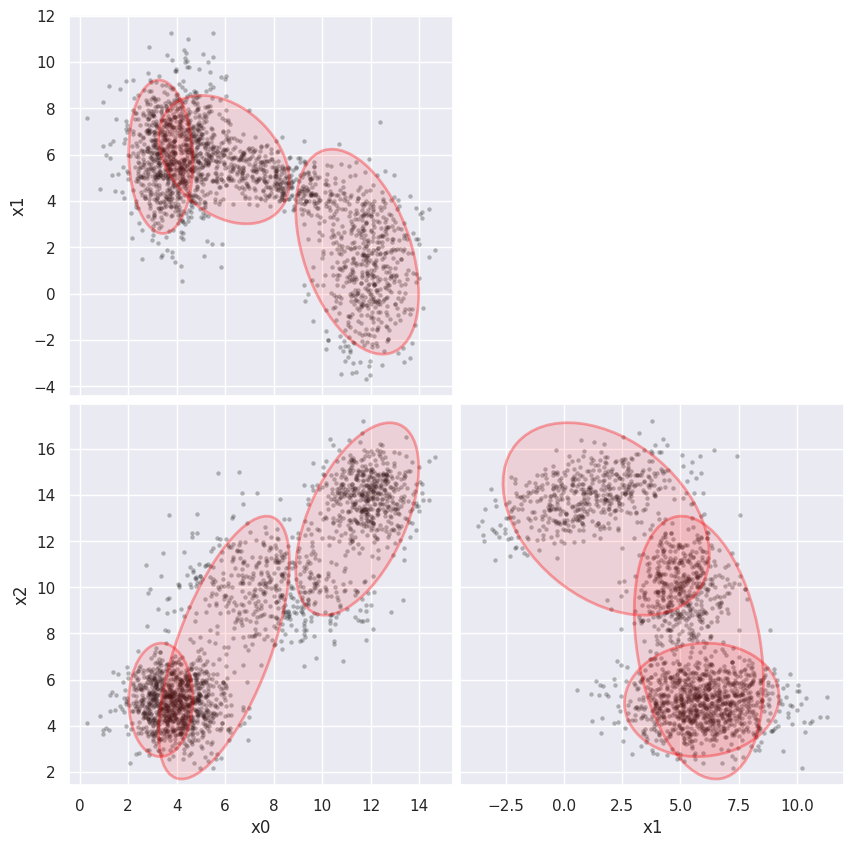

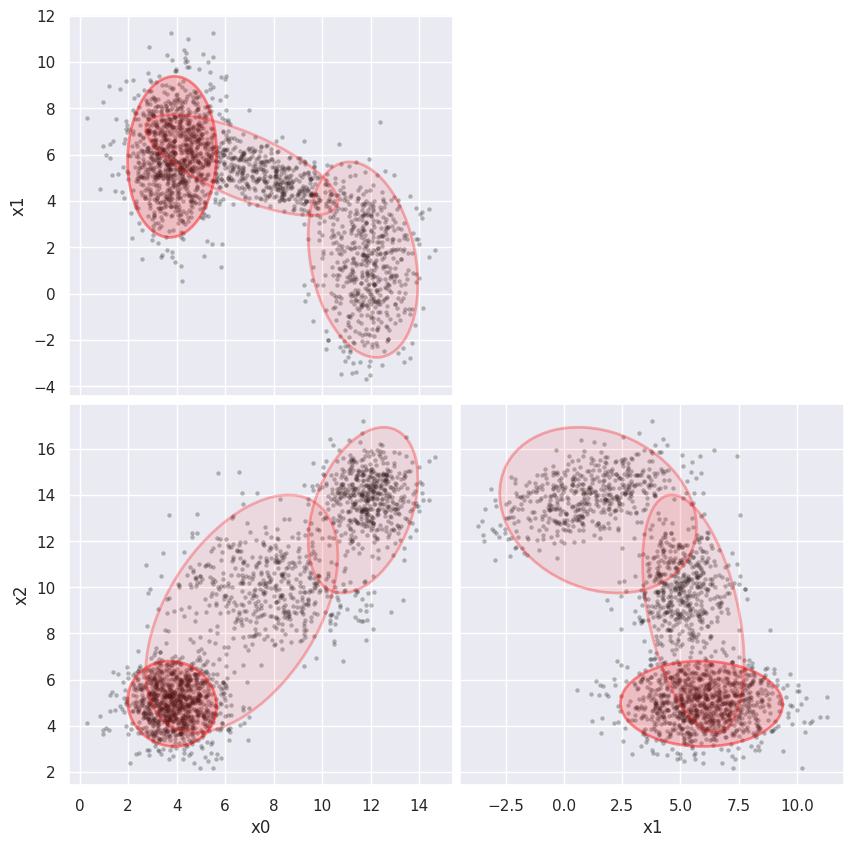

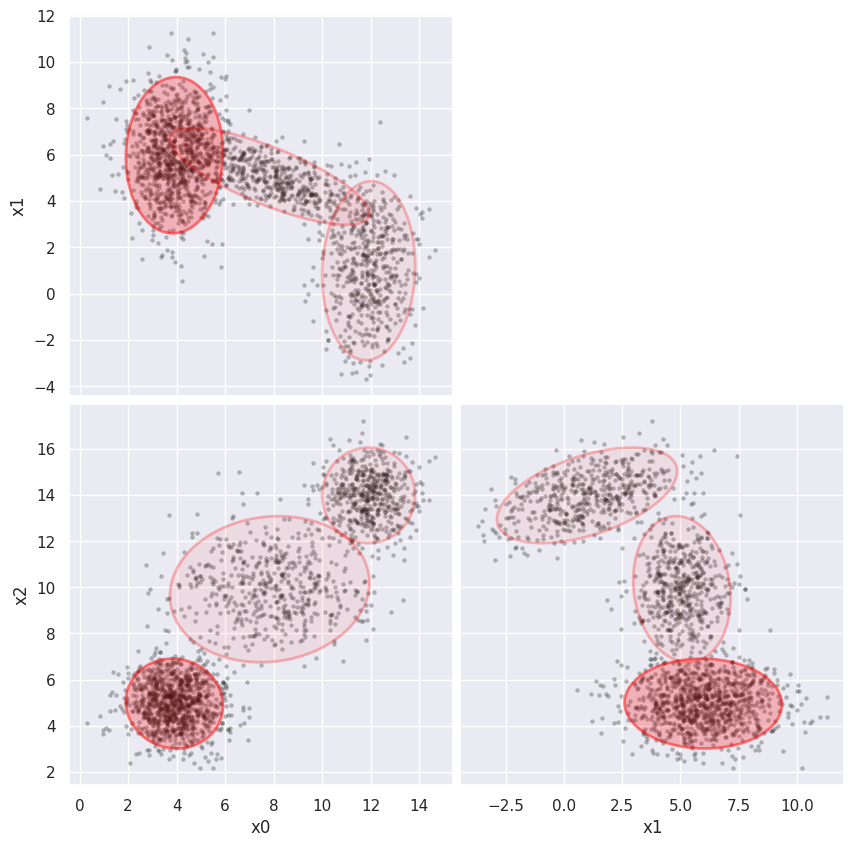

In [16]:
GMM_fit(blobs_data, 3, nsteps=0)
GMM_fit(blobs_data, 3, nsteps=4)
GMM_fit(blobs_data, 3, nsteps=8)

Convergence is even faster if you use KMeans to initialize the relative weights (which is why most implementations do this):

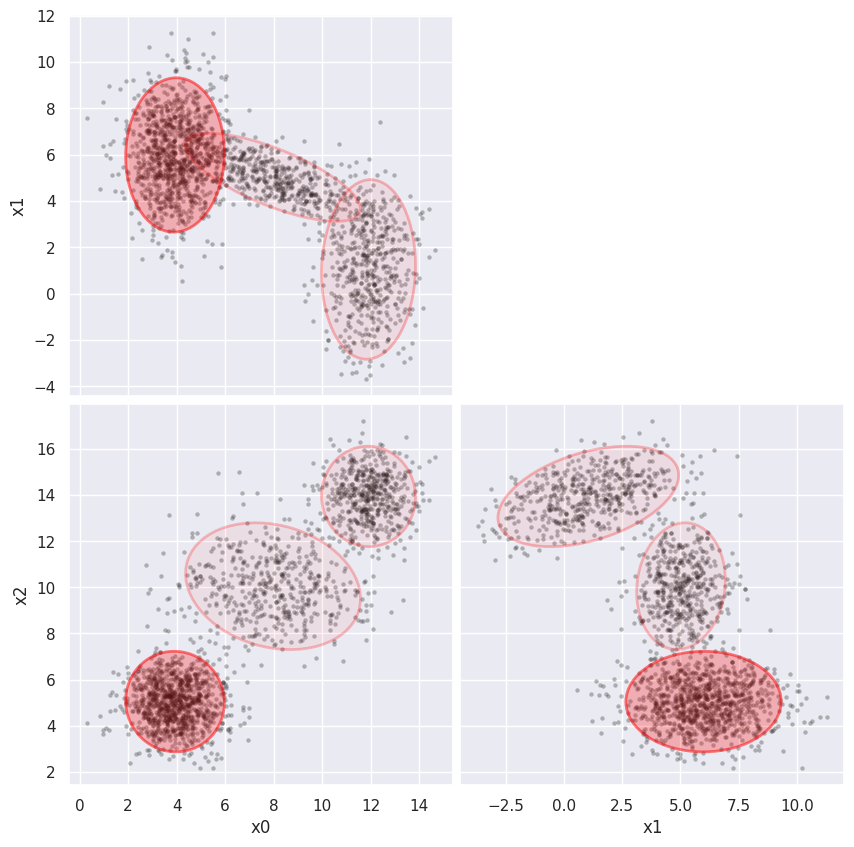

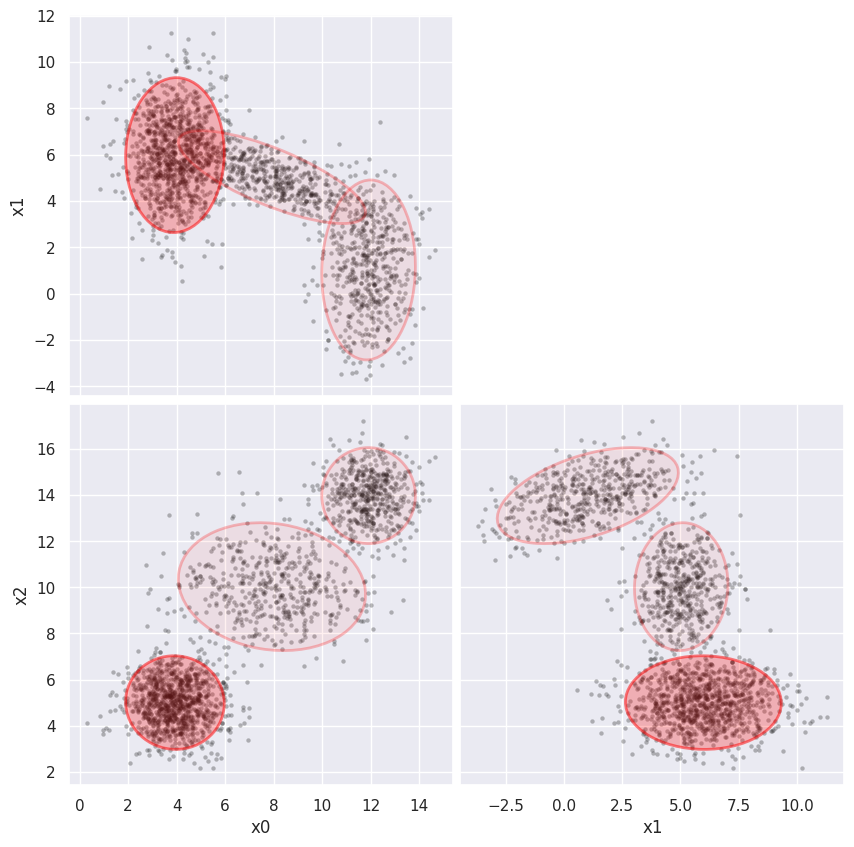

In [17]:
GMM_fit(blobs_data, 3, nsteps=0, init='kmeans')
GMM_fit(blobs_data, 3, nsteps=1, init='kmeans')

## <span style="color:Orange">Problem 2</span>

A density estimator should provide a probability density function $P(\vec{x})$ that is normalized over its feature space $\vec{x}$

$$ \Large
\int d\vec{x}\, P(\vec{x}) = 1 \; .
$$

In this problem you will verify this normalization for KDE using two different numerical approaches for the integral.

First, implement the function below to accept a 1D KDE fit object and estimate its normalization integral using the trapezoid rule with the specified grid. *Hint: the `np.trapz` function will be useful.*

In [18]:
def check_grid_normalization(fit, xlo, xhi, ngrid):
    """Check 1D denstity estimator fit result normlization using grid quadrature.

    Parameters
    ----------
    fit : neighbors.KernelDensity fit object
        Result of fit to 1D dataset.
    xlo : float
        Low edge of 1D integration range.
    xhi : float
        High edge of 1D integration range.
    ngrid : int
        Number of equally spaced grid points covering [xlo, xhi],
        including both end points.
    """
    # YOUR CODE HERE
    x = np.linspace(xlo, xhi, ngrid)
    y = np.exp(fit.score_samples(x[:, None]))
    return np.trapz(y, x)
    #raise NotImplementedError()


In [19]:
# A correct solution should pass these tests.
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']).values)
assert np.round(check_grid_normalization(fit, 0, 15, 5), 3) == 1.351
assert np.round(check_grid_normalization(fit, 0, 15, 10), 3) == 1.019
assert np.round(check_grid_normalization(fit, 0, 15, 20), 3) == 0.986
assert np.round(check_grid_normalization(fit, 0, 15, 100), 3) == 1.000

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x2']).values)
assert np.round(check_grid_normalization(fit, -4, 12, 5), 3) == 1.108
assert np.round(check_grid_normalization(fit, -4, 12, 10), 3) == 0.993
assert np.round(check_grid_normalization(fit, -4, 12, 20), 3) == 0.971
assert np.round(check_grid_normalization(fit, -4, 12, 100), 3) == 1.000

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x1']).values)
assert np.round(check_grid_normalization(fit, 2, 18, 5), 3) == 1.311
assert np.round(check_grid_normalization(fit, 2, 18, 10), 3) == 0.954
assert np.round(check_grid_normalization(fit, 2, 18, 20), 3) == 1.028
assert np.round(check_grid_normalization(fit, 2, 18, 100), 3) == 1.000

/tmp/ipython-input-1382982853.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)
/tmp/ipython-input-1382982853.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)
/tmp/ipython-input-1382982853.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)
/tmp/ipython-input-1382982853.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)
/tmp/ipython-input-1382982853.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)
/tmp/ipython-in

Next, implement the function below to estimate a multidimensional fit normalization using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration):

$$ \Large
\int d\vec{x}\, P(\vec{x}) \simeq \frac{V}{N_{mc}}\, \sum_{j=1}^{N_{mc}} P(\vec{x}_j) = V \langle P\rangle \; ,
$$

where the $\vec{x}_j$ are uniformly distributed over the integration domain and $V$ is the integration domain volume. Note that `trapz` gives more accurate results for a fixed number of $P(\vec{x})$ evaluations, but MC integration is much easier to generalize to higher dimensions.

In [20]:
def check_mc_normalization(fit, xlo, xhi, nmc, seed=123):
    """Check denstity estimator fit result normlization using MC integration.

    Parameters
    ----------
    fit : neighbors.KernelDensity fit object
        Result of fit to arbitrary dataset of dimension D.
    xlo : array
        1D array of length D with low limits of integration domain along each dimension.
    xhi : array
        1D array of length D with high limits of integration domain along each dimension.
    nmc : int
        Number of random MC integration points within the domain to use.
    """
    xlo = np.asarray(xlo)
    xhi = np.asarray(xhi)
    assert xlo.shape == xhi.shape
    assert np.all(xhi > xlo)
    D = len(xlo)
    gen = np.random.RandomState(seed=seed)
    # Use gen.uniform() in your solution, not gen.rand(), for consistent random numbers.
    # YOUR CODE HERE
    x = gen.uniform(xlo, xhi, (nmc, D))
    y = np.exp(fit.score_samples(x))
    return (xhi - xlo).prod() * np.mean(y)
    #raise NotImplementedError()

In [21]:
##### A correct solution should pass these tests.
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']).values)
assert np.round(check_mc_normalization(fit, [0], [15], 10), 3) == 1.129
assert np.round(check_mc_normalization(fit, [0], [15], 100), 3) == 1.022
assert np.round(check_mc_normalization(fit, [0], [15], 1000), 3) == 1.010
assert np.round(check_mc_normalization(fit, [0], [15], 10000), 3) == 0.999

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x2']).values)
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10), 3) == 1.754
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 100), 3) == 1.393
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 1000), 3) == 0.924
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10000), 3) == 1.019

fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.values)
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10), 3) == 2.797
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 100), 3) == 0.613
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 1000), 3) == 1.316
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10000), 3) == 1.139

## <span style="color:Orange">Problem 3</span>

In this problem, you will study the accuracy of Monte Carlo integration in each of four different expressions, each with some physical significance, shown in the table below:

| Expression # | Function &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;  &nbsp;|Interval|Notes|
|---|---|---|---|
|1. |${x = \int_0^1 7-10t\ dt} $| $t$ is time; $t = [0, 1]$ s |Gives position at <br>time $t$ for this system|
|2. |${\Delta S}$ ${= \int_{300}^{400}\frac{mc}{T}\ dT }$|$m$ is mass; $m=1$ kg<br> $c$ is specific heat capacity; $c = 4190$ J/kg K<br>$T$ is temperature; $T = [300, 400]$ K|Change in entropy for <br>thermal processes|
|3. |$\Phi = \int_1^2 \frac{Q}{4 \pi \epsilon_o r^2} dr$|$r$ is distance; $r = [1, 2]$ m<br>$\epsilon_o$ is the Permittivity of Free Space<br>$Q$ is the charge; $Q = 1$ C|$\Phi$ is the electric potential energy <br>gained by moving along line $r$|
|4. |$I = \int_0^\infty \frac{2 \pi h c^2}{\lambda^5(e^{hc/\lambda k T} - 1)}\ d\lambda$|$h$ is Planck's constant<br> $c$ is speed of light <br> $k$ is Boltzmann's Constant <br> $T$ is the absolute temperature; T = 400K <br> $\lambda$ is wavelength; $\lambda = [0, \infty]$ m|Planck's radiation law; <br>Integrating gives Stefan Boltzmann Law|

Analytically integrate each for the region and values provided, and record your answer in the `analytical_result` variables below:

In [22]:
analytical_result_expr1 = 2.0 # replace the None's with your results
analytical_result_expr2 = 4190.0 * np.log(400.0/300.0)
eps0 = 8.854187817e-12
analytical_result_expr3 = 1.0 / (8.0 * np.pi * eps0)
sigma = 5.6704e-8
analytical_result_expr4 = sigma * (400.0**4)
print("Analytical Results:")
print("Expr1 =", analytical_result_expr1)
print("Expr2 =", analytical_result_expr2)
print("Expr3 =", analytical_result_expr3)
print("Expr4 =", analytical_result_expr4)

Analytical Results:
Expr1 = 2.0
Expr2 = 1205.3878835729618
Expr3 = 4493775893.998956
Expr4 = 1451.6224


Show your work in the cell below, either in a picture file for written derivations or in Latex

### Analytical Integration of the Four Expressions

#### 1. Position integral
We compute
$$
x = \int_0^1 (7 - 10t)\, dt
$$
Evaluate term by term:
$$
\int_0^1 7\, dt = 7t \Big|_0^1 = 7
$$
$$
\int_0^1 10t\, dt = 5t^2 \Big|_0^1 = 5
$$
Therefore,
$$
x = 7 - 5 = 2
$$

---

#### 2. Entropy change
We compute
$$
\Delta S = \int_{300}^{400} \frac{mc}{T}\, dT
$$
with $m = 1 \, \text{kg}, \; c = 4190 \, \text{J/kg K}$.  
Take constants out:
$$
\Delta S = mc \int_{300}^{400} \frac{1}{T}\, dT
= mc \, \ln T \Big|_{300}^{400}
$$
$$
\Delta S = mc \, \ln\!\left(\frac{400}{300}\right)
= 4190 \, \ln\!\left(\tfrac{4}{3}\right)
$$

---

#### 3. Electric potential integral
We compute
$$
\Phi = \int_{1}^{2} \frac{Q}{4\pi \epsilon_0 r^2}\, dr
$$
Take constants out:
$$
\Phi = \frac{Q}{4\pi \epsilon_0} \int_{1}^{2} \frac{1}{r^2}\, dr
$$
The integral is
$$
\int_{1}^{2} r^{-2}\, dr = \left[ -\frac{1}{r} \right]_1^2
= -\frac{1}{2} + 1 = \frac{1}{2}
$$
So
$$
\Phi = \frac{Q}{4\pi \epsilon_0} \cdot \frac{1}{2}
= \frac{Q}{8\pi \epsilon_0}
$$
For $Q = 1 \, \text{C}$:
$$
\Phi = \frac{1}{8 \pi \epsilon_0}
$$

---

#### 4. Stefan–Boltzmann integral
We compute
$$
I = \int_0^\infty \frac{2 \pi h c^2}{\lambda^5 \left(e^{hc/(\lambda k T)} - 1\right)}\, d\lambda
$$
This is the Planck radiation law integral.  
The exact evaluation gives the Stefan–Boltzmann law:
$$
I = \sigma T^4
$$
where
$$
\sigma = \frac{2 \pi^5 k^4}{15 h^3 c^2}
$$
is the Stefan–Boltzmann constant.  
For $T = 400 \, \text{K}$:
$$
I = \sigma (400)^4
$$


Write the each expression to be integrated as a python function.  

> For example, if I want to integrate the expression
>
> $$ \Large
> F = \int 3x^2 + 17\ dx
> $$
>
> then my integrand is
>
> $$ \Large
> f(x) = 3x^2 + 17
> $$
>
> and I would write the following function:
> ```
> def integrand(x):
>     f_x = 3*np.power(x, 2) + 17
>     return f_x
> ```
>
> This function takes `x` as my function argument, and returns the calculated value `f_x`.  Note that I am not yet evaluating the limits of my integrand.

In [23]:
# Helpful constants:
pi = np.pi #unitless
c = 2.99E8 #m/s
h = 6.62607015E-34 #J
k = 1.380649E-23 #J/K
epsilon = 8.854187817E-12 #F/m
sigma = 5.6704E-8 #W/(m^2 K^4)

In [24]:
def integrand_f1(t):
    return 7 - 10*t

def integrand_f2(T):
    m, c = 1.0, 4190.0
    return m*c / T

def integrand_f3(r):
    Q = 1.0
    return Q / (4*np.pi*eps0 * r**2)

def integrand_f4(lam):
    h = 6.62607015e-34
    c = 2.998e8
    k = 1.380649e-23
    T = 400.0
    return (2*np.pi*h*c**2) / (lam**5 * (np.exp(h*c/(lam*k*T)) - 1))

    # raise NotImplementedError()

Randomly choose values for `x` from a distribution between the limits of the definite integral.

>*Hint*: if one of your limits is $\infty$, it is okay to approximate it with a large number.  Another way to do it is to plot [x, f(x)] and visually estimate the most important region of your integration.

In [25]:
'''
lower_limit = # this can be a float
upper_limit = # this can be a float
num_x_vals  = # this must be an integer value less than or equal to 10^8
x_vals = np.random.uniform(lower_limit, upper_limit, num_x_vals)
'''
# I will define a function that achieve all the functions of the following cells:

def monte_carlo_integration(func, lower, upper, N, analytical):
    # Sample random x values
    x_vals = np.random.uniform(lower, upper, N)
    y_vals = func(x_vals)
    approx = (upper - lower) * np.mean(y_vals)

    # Error metrics
    mse = np.mean((approx - analytical)**2)
    pe = abs((approx - analytical) / analytical) * 100
    return approx, mse, pe, y_vals

Calculate the `f_x` values:

In [26]:
# y = integrand(x_vals)

In [27]:
# approx_int = ((upper_limit - lower_limit)*np.sum(y))/(num_x_vals - 1)
# print(f"The Monte Carlo approximation is {approx_int}")

Calculate the error between the `approx_int` and the `analytical_result` variables using one or more of the metrics discussed above

In [28]:
'''
mse = None # replace with your calculation
print(f"The Mean Squared Error is {mse}")

pe = None # replace with your calculation
print(f"The Percent Error is {pe}%")
'''
# I will use my function to calculate the MC approximation and MSE and PE
N = 200000   # number of samples per test

approx1, mse1, pe1, y1 = monte_carlo_integration(integrand_f1, 0, 1, N, analytical_result_expr1)
approx2, mse2, pe2, y2 = monte_carlo_integration(integrand_f2, 300, 400, N, analytical_result_expr2)
approx3, mse3, pe3, y3 = monte_carlo_integration(integrand_f3, 1, 2, N, analytical_result_expr3)
approx4, mse4, pe4, y4 = monte_carlo_integration(integrand_f4, 1e-9, 1e-4, N, analytical_result_expr4)  # approximate inf by 1e-4， if set upper limit too large, then the sample will drop to most areas are zero

print("\nMonte Carlo Approximations:")
print(f"Expr1: {approx1:.5f}, MSE={mse1:.5e}, PE={pe1:.3f}%")
print(f"Expr2: {approx2:.5f}, MSE={mse2:.5e}, PE={pe2:.3f}%")
print(f"Expr3: {approx3:.5f}, MSE={mse3:.5e}, PE={pe3:.3f}%")
print(f"Expr4: {approx4:.5f}, MSE={mse4:.5e}, PE={pe4:.3f}%")


Monte Carlo Approximations:
Expr1: 1.99943, MSE=3.25101e-07, PE=0.029%
Expr2: 1205.51210, MSE=1.54292e-02, PE=0.010%
Expr3: 4493113147.02503, MSE=4.39234e+11, PE=0.015%
Expr4: 1442.27495, MSE=8.73749e+01, PE=0.644%


/tmp/ipython-input-516843040.py:17: RuntimeWarning: overflow encountered in exp
  return (2*np.pi*h*c**2) / (lam**5 * (np.exp(h*c/(lam*k*T)) - 1))


Finally, we want to visualize how the error decreases as the number of random trials `num_x_vals` increases.  Write code to the do the following:

* Using the error metric you decided on above, write a for-loop that calculates the error as a function of the number of points you sampled.  For example, calculate the error when you summed two values of $\langle F^N \rangle$, then calculate the error for three summed values of $\langle F^N \rangle$, and so on until you have calculated the errors for the full range of $\langle F^N \rangle$.

* IMPORTANT: You do not need to re-do the experiment to calculate this analysis; if you do it will slow down your for-loop and potentially crash your notebook kernel.  Instead, you will want to reuse all of the integrand values are stored in the `y` variable.  Python indexing into this list using the `y[:N]` functionality will give you the first `N` values in this list.  The first `N` values can then be used to calculate a $\langle F^N \rangle$ value for the first `N` samples.

* Make a figure showing how the error changes with the number of values in the sum.

In [29]:
# error_data = []
# Write code here to fill error_data with the percentage error corresponding to each of the number of points you sampled in the MC integration
def error_curve(func, lower, upper, y_vals, analytical):
    error_data = []
    for N in range(2, 2000000):   # from 2 to 2e6
        approx = (upper - lower) * np.mean(y_vals[:N])
        pe = abs((approx - analytical) / analytical) * 100
        error_data.append(pe)
    return error_data

error_data1 = error_curve(integrand_f1, 0, 1, y1, analytical_result_expr1)
error_data2 = error_curve(integrand_f2, 300, 400, y2, analytical_result_expr2)
error_data3 = error_curve(integrand_f3, 1, 2, y3, analytical_result_expr3)
error_data4 = error_curve(integrand_f4, 1e-9, 1e-4, y4, analytical_result_expr4)


Finally, plot it

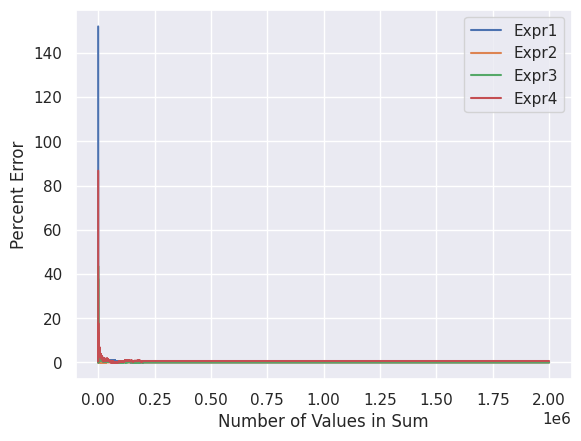

In [30]:
'''
plt.plot(np.linspace(2, 2000000, 1999998, endpoint=True), error_data)
plt.xlabel("Number of Values in Sum")
plt.ylabel("Percent Error")
'''
plt.plot(np.linspace(2, 2000000, 1999998, endpoint=True), error_data1, label="Expr1")
plt.plot(np.linspace(2, 2000000, 1999998, endpoint=True), error_data2, label="Expr2")
plt.plot(np.linspace(2, 2000000, 1999998, endpoint=True), error_data3, label="Expr3")
plt.plot(np.linspace(2, 2000000, 1999998, endpoint=True), error_data4, label="Expr4")
plt.xlabel("Number of Values in Sum")
plt.ylabel("Percent Error")
plt.legend()
plt.show()

<span style="color:Violet">Answer the following questions</span>:

- Model vs Simulation: In your own words, describe the difference between a model and a simulation.  Give your own example of a model, and how you would simulate it.

> **Answer: A model is basically a simplified way of describing a real system, usually with equations or rules. A simulation is when you actually “run” the model on a computer (or by hand) to see how it behaves.**

> **Example:**  
A model for population growth is $\frac{dN}{dt} = rN$.  
To simulate it, I could write a small program to update the population step by step and plot how it changes over time.

- Markov Chain: In your own words, describe a Markov Chain and its properties. Give your own example of a stochastic system and how you would implement a Markov Chain for it.

> **Answer: A Markov Chain is a random process where the next step only depends on the current step, not on the full history.**

> **Example:**  
Think about the weather: if it’s sunny today, maybe there’s an 80% chance tomorrow is sunny and 20% chance it rains. If it rains today, maybe 50% chance tomorrow rains and 50% chance it’s sunny.  
This kind of system can be simulated by starting with “sunny” or “rainy” and then randomly picking the next state according to those probabilities.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025